In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import anndata
import datetime
#import rapids_singlecell as rsc
#import cudf
#import cupy as cp
import scanpy as sc
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer

import warnings
from scipy.stats import zscore

import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
plt.rcParams['font.size'] = 16
#import rmm
#from rmm.allocators.cupy import rmm_cupy_allocator

#rmm.reinitialize(
#    managed_memory=False,  # Allows oversubscription
#    pool_allocator=False,  # default is False
#    devices=[0, 1, 2, 3],  # GPU device IDs to register. By default registers only GPU 0.
#)
#cp.cuda.set_allocator(rmm_cupy_allocator)

In [2]:
print(np.__version__)

1.19.5


In [3]:
data_GO = pd.read_csv(filepath_or_buffer="/export3/Imaging/atlas_for_fig/GOvsID_6region_removed.csv", encoding="ms932", sep=",")
# data_GO["id"]のユニークな値を取得
ids = data_GO["id"].astype(int)
ids=np.array(ids)
data_GO

,id,graph_order,R,G,B
0,997,0,255,255,255
1,68,7,38,143,69
2,667,8,38,143,69
3,52192,9,38,143,69
4,52196,10,38,143,69
...,...,...,...,...,...
666,129,1299,170,170,170
667,140,1300,170,170,170
668,145,1301,170,170,170
669,153,1302,170,170,170


In [5]:
# 下記は一部のidだけが対象
dir= "/export3/Imaging/cubic-atlas_v1-1/cubic-atlas/"
dir_ana=dir+"summary_CUBIC-Atlas-1-1.csv"


data_id = pd.read_csv(filepath_or_buffer=dir_ana, encoding="ms932", sep=",")
data_id

,id,acronym,node_name,graph_order,rgb_triplet,cell_count,volume(mm3),density(cells/mm3)
0,997,root,root,0,"[255, 255, 255]",78620375,506.05289,155359.99590
1,8,grey,Basic cell groups and regions,1,"[191, 218, 227]",70525778,449.60086,156863.08540
2,567,CH,Cerebrum,2,"[176, 240, 255]",39291452,275.87673,142423.94190
3,688,CTX,Cerebral cortex,3,"[176, 255, 184]",31750427,221.54964,143310.66800
4,695,CTXpl,Cortical plate,4,"[112, 255, 112]",30687805,212.64380,144315.54300
...,...,...,...,...,...,...,...,...
834,129,V3,third ventricle,1299,"[170, 170, 170]",144614,0.90005,160673.85380
835,140,AQ,cerebral aqueduct,1300,"[170, 170, 170]",26972,0.40620,66400.27696
836,145,V4,fourth ventricle,1301,"[170, 170, 170]",118275,0.96495,122570.72070
837,153,V4r,lateral recess,1302,"[170, 170, 170]",71934,0.46333,155254.98260


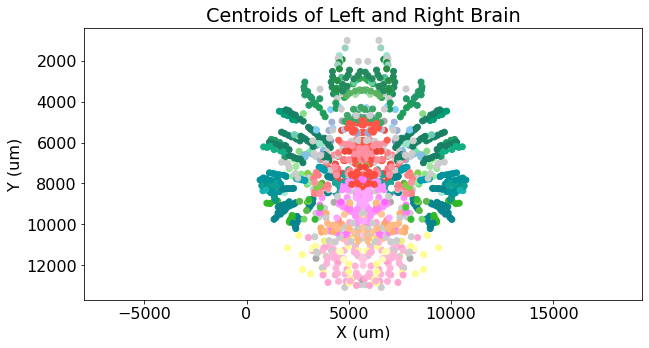

In [6]:
# whole brain plotをする
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# バイナリファイルを読み込む
dt_type = np.dtype([
  ('X(um)', 'f4'), ('Y(um)', 'f4'), ('Z(um)', 'f4'), ('atlasID', 'u2')
])
grid_points = np.fromfile("/export3/Imaging/ds4_Data4/atlas/annotation_50_non_zero_coordinates.bin", dt_type)
grid_points = pd.DataFrame(grid_points)

# 左脳と右脳のデータを分割
left_points = grid_points[grid_points['X(um)'] < 5700]
right_points = grid_points[grid_points['X(um)'] >= 5700]

# atlasIDごとに重心を計算する関数
def calculate_centroids(df):
    centroids = df.groupby('atlasID').agg({'X(um)': 'mean', 'Y(um)': 'mean', 'Z(um)': 'mean'}).reset_index()
    return centroids

# 左脳と右脳の重心を計算
left_centroids = calculate_centroids(left_points)
right_centroids = calculate_centroids(right_points)

# 重心データを結合
all_centroids = pd.concat([left_centroids, right_centroids])



# 色情報の辞書を生成
color_dict = {row['id']: (row['R']/255, row['G']/255, row['B']/255) for index, row in data_GO.iterrows()}

# atlasIDに基づいて各点の色を決定
all_centroids['color'] = all_centroids['atlasID'].map(color_dict).apply(lambda x: x if isinstance(x, tuple) else (0.5, 0.5, 0.5))  # 色が見つからない場合は灰色

# xy座標をプロット（すべての重心を1つのプロットに表示）
plt.figure(figsize=(10, 5))
plt.scatter(all_centroids['X(um)'], all_centroids['Y(um)'], color=all_centroids['color'].tolist())
plt.title('Centroids of Left and Right Brain')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.axis('equal')  # 軸を等方的にする
plt.gca().invert_yaxis()  # Y軸を反転
plt.show()


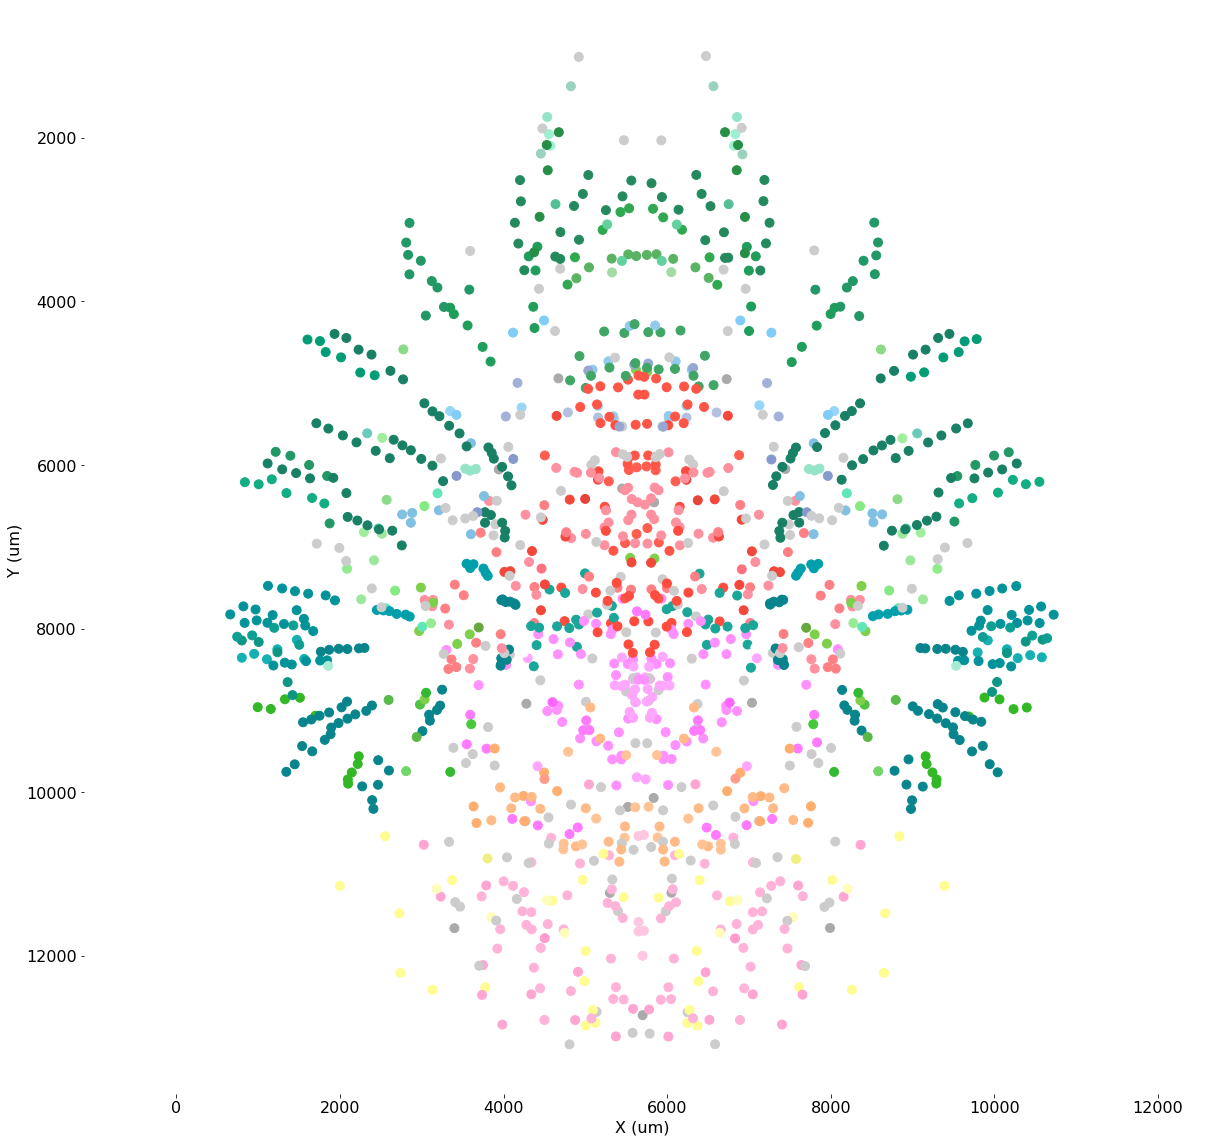

In [7]:
plt.figure(figsize=(20, 20))
plt.scatter(all_centroids['X(um)'], all_centroids['Y(um)'], s=80, color=all_centroids['color'].tolist())
#plt.title('Centroids of Left and Right Brain')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.axis('equal')  # 軸を等方的にする
plt.gca().invert_yaxis()  # Y軸を反転
plt.gca().spines['top'].set_visible(False)  # 上の軸線を非表示
plt.gca().spines['right'].set_visible(False)  # 右の軸線を非表示
plt.gca().spines['left'].set_visible(False)  # 左の軸線を非表示
plt.gca().spines['bottom'].set_visible(False)  # 下の軸線を非表示
#plt.xticks([])  # X軸の目盛りを非表示
#plt.yticks([])  # Y軸の目盛りを非表示
plt.show()


Start time: 2024-11-04 11:35:53.177297


/home/mitani/my_env/lib64/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


0      0.815325
1      0.054719
2      0.381347
3      0.929433
4      0.194832
         ...   
666    0.937328
667    0.655858
668    0.944422
669    0.752759
670    0.985973
Name: dpt_pseudotime, Length: 671, dtype: float32


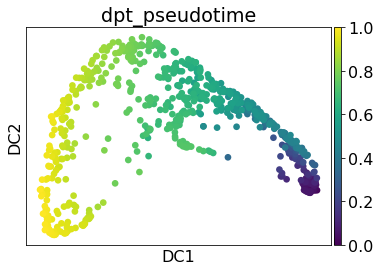

End time after X: 2024-11-04 11:35:56.296968
Duration for UMAP: 0:00:03.119671


In [9]:
import datetime
import pandas as pd
import numpy as np
from scipy.stats import zscore
import anndata
import scanpy as sc

start_time = datetime.datetime.now()
print("Start time:", start_time)

# CSVファイルを読み込む
X = pd.read_csv('/export3/Imaging/ds4_Data4/Region/APP_raw_value_regions_Abeta_all.csv', index_col='atlasID')

# 欠損値を各列の平均値で埋める
data_pivot = X#.apply(lambda col: col.fillna(col.mean()) if not col.isnull().all() else col.fillna(0))


# Zスコアでデータを正規化し、ゼロ分散を持つ行に対してNaNを0に置換
data_normalized = data_pivot.apply(zscore, axis=1).fillna(0)

# 各行がリストになっているので、それを展開して2次元のnumpy配列に変換
X_matrix = np.vstack(data_normalized)

# 無効な値（NaNや無限大）が含まれていないか確認し、置換
X_matrix_cleaned = np.nan_to_num(X_matrix, nan=0, posinf=0, neginf=0)



# AnnDataオブジェクトに変換
adata = anndata.AnnData(X_matrix_cleaned)

# 最近傍グラフの計算
sc.pp.neighbors(adata, use_rep='X', n_neighbors=15)

# ルートセルの設定
adata.uns['iroot'] = 634

# 拡散マップの計算
sc.tl.diffmap(adata)

# 疑似時間の計算
sc.tl.dpt(adata)

# 疑似時間の表示
print(adata.obs['dpt_pseudotime'])

# 拡散マップを表示
sc.pl.diffmap(adata, color=['dpt_pseudotime'], cmap='viridis',show=False)

# plt.savefigで直接PDFに保存
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Abeta_pseudotime_diffusion_map.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot (not necessary if it's already saved, but optional)
plt.show()


# 実行時間の計測
end_time1 = datetime.datetime.now()
print("End time after X:", end_time1)
print("Duration for UMAP:", end_time1 - start_time)


/home/mitani/my_env/lib64/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/mitani/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


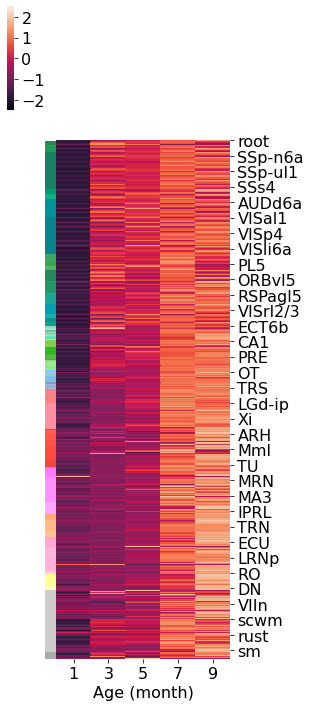

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 欠損値を列ごとの平均で埋める
data_pivot = X.apply(lambda col: col.fillna(col.mean()) if not col.isnull().all() else col.fillna(0))

# Zスコアで正規化し、NaNを0で置換
data_normalized = data_pivot.apply(zscore, axis=1)

# リスト状のデータを各列に展開
data_normalized_df = pd.DataFrame(data_normalized.tolist(), index=data_normalized.index)
# リスト状のデータを各列に展開
#data_normalized_df = pd.DataFrame(data_normalized.values, index=data_normalized.index)

# NaN 値を 0 で置換
data_normalized_df = data_normalized_df.fillna(0)

# adata.obs のインデックスに対応する atlasID を data_normalized_df のインデックスに基づいて再設定
adata.obs['atlasID'] = data_normalized_df.index

# data_normalized_df のインデックスに基づいて、すべての atlasID に対応する dpt_pseudotime を取得
# atlasID に基づいてマージ
merged_data = pd.merge(
    data_normalized_df, 
    adata.obs[['atlasID', 'dpt_pseudotime']], 
    left_index=True, right_on='atlasID', 
    how='left'
)

# pseudotime に基づいて並べ替え
merged_data = merged_data.sort_values(by='dpt_pseudotime')

# 並べ替え後に pseudotime をデータから取り出す
sorted_pseudotime_full = merged_data['dpt_pseudotime']

# 並べ替えられたデータを整理
sorted_data_df = merged_data.drop(columns=['atlasID', 'dpt_pseudotime'])

# データがすべて数値であることを確認
sorted_data_df = sorted_data_df.apply(pd.to_numeric, errors='coerce')

# NaNや無効な値を確認し、すべてを数値に変換
sorted_data_df = sorted_data_df.fillna(0)
sorted_data_df = sorted_data_df.astype(float)

# 元の atlasID を取得し、sorted_data_df のインデックスに再設定する
sorted_data_df.index = merged_data['atlasID']

# data_GO の id の順番に従って並び替える
sorted_order = data_GO['id']  # 並び替え順
sorted_data_df = sorted_data_df.reindex(sorted_order)

# acronymのインデックスを取得するために、sorted_data_df.index と data_id['id'] の共通部分のみを使用
acronyms = data_id.set_index('id').loc[sorted_data_df.index, 'acronym']

# colorlist の生成（atlasID と一致させる）
colorlist = []
for atlas_id in sorted_data_df.index:
    if atlas_id in data_GO['id'].values:
        match = data_GO[data_GO['id'] == atlas_id]
        color = (match['R'].values[0] / 255, match['G'].values[0] / 255, match['B'].values[0] / 255)
        colorlist.append(color)

# 色リストがソートされたインデックスに対応しているかを確認
if len(colorlist) == len(sorted_data_df):
    colorlist_671 = colorlist
else:
    print(f"色リストの長さがデータと一致していません。"
          f"colorlist length: {len(colorlist)}, data length: {len(sorted_data_df)}")

# カスタムカラーマップを作成
def create_custom_cmap():
    # Colors: cyan, black, yellow
    colors = ["#00ffff", "#000000", "#ffff00"]
    cmap_name = "custom_cmap"
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)
    return cmap

cmap = create_custom_cmap()

# clustermapプロット
g = sns.clustermap(sorted_data_df,  row_colors=colorlist_671, vmin=-2.5, vmax=2.5, 
                   row_cluster=False, col_cluster=False, figsize=(4, 12))

# x軸のラベルを 1, 3, 5, 7, 9 に変更
g.ax_heatmap.set_xticks(np.arange(len(sorted_data_df.columns))+0.5)  # デフォルトの位置に x の ticks を配置
g.ax_heatmap.set_xticklabels([1, 3, 5, 7, 9], rotation=0)  # ラベルを 1, 3, 5, 7, 9 に変更

# x軸のタイトルを Age (month) に設定
g.ax_heatmap.set_xlabel("Age (month)")#, fontsize=12)
g.ax_heatmap.set_ylabel("", fontsize=12)
# y軸のラベル（region名）を設定
step = 20  # ラベルの間隔を調整
g.ax_heatmap.set_yticks(np.arange(0, len(acronyms), step))
g.ax_heatmap.set_yticklabels(acronyms[::step], rotation=0)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Regional_Abeta_heatmap_before_Pseudotime_reordered.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


/home/mitani/my_env/lib64/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/mitani/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

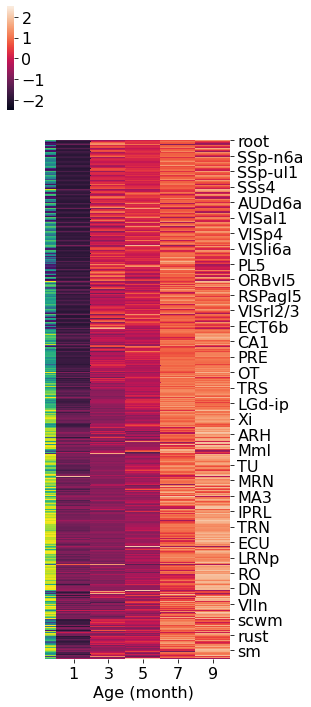

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 欠損値を列ごとの平均で埋める
data_pivot = X.apply(lambda col: col.fillna(col.mean()) if not col.isnull().all() else col.fillna(0))

# Zスコアで正規化し、NaNを0で置換
data_normalized = data_pivot.apply(zscore, axis=1)

# リスト状のデータを各列に展開
data_normalized_df = pd.DataFrame(data_normalized.tolist(), index=data_normalized.index)
# リスト状のデータを各列に展開
#data_normalized_df = pd.DataFrame(data_normalized.values, index=data_normalized.index)

# NaN 値を 0 で置換
data_normalized_df = data_normalized_df.fillna(0)

# adata.obs のインデックスに対応する atlasID を data_normalized_df のインデックスに基づいて再設定
adata.obs['atlasID'] = data_normalized_df.index

# data_normalized_df のインデックスに基づいて、すべての atlasID に対応する dpt_pseudotime を取得
# atlasID に基づいてマージ
merged_data = pd.merge(
    data_normalized_df, 
    adata.obs[['atlasID', 'dpt_pseudotime']], 
    left_index=True, right_on='atlasID', 
    how='left'
)

# pseudotime に基づいて並べ替え
merged_data = merged_data.sort_values(by='dpt_pseudotime')

# 並べ替え後に pseudotime をデータから取り出す
sorted_pseudotime_full = merged_data['dpt_pseudotime']

# 並べ替えられたデータを整理
sorted_data_df = merged_data.drop(columns=['atlasID', 'dpt_pseudotime'])

# データがすべて数値であることを確認
sorted_data_df = sorted_data_df.apply(pd.to_numeric, errors='coerce')

# NaNや無効な値を確認し、すべてを数値に変換
sorted_data_df = sorted_data_df.fillna(0)
sorted_data_df = sorted_data_df.astype(float)

# 元の atlasID を取得し、sorted_data_df のインデックスに再設定する
sorted_data_df.index = merged_data['atlasID']

# data_GO の id の順番に従って並び替える
sorted_order = data_GO['id']  # 並び替え順
sorted_data_df = sorted_data_df.reindex(sorted_order)

# sorted_data_df.indexに対応するdpt_pseudotimeを取得するためにマッピング
sorted_pseudotime_full = pd.DataFrame(merged_data[['atlasID', 'dpt_pseudotime']])

# sorted_data_df のインデックス（atlasID）に基づいて pseudotime を並べ替える
sorted_pseudotime_full = sorted_pseudotime_full.set_index('atlasID').reindex(sorted_data_df.index)

# Viridisカラーマップを使って pseudotime_colors を設定
viridis = plt.cm.get_cmap('viridis', 256)
norm = plt.Normalize(vmin=0, vmax=1)
pseudotime_colors = viridis(norm(sorted_pseudotime_full['dpt_pseudotime']))

# プロットをクリアするために挿入
plt.clf()

# clustermapプロット
g = sns.clustermap(sorted_data_df, row_colors=pseudotime_colors, vmin=-2.5, vmax=2.5, 
                   row_cluster=False, col_cluster=False, figsize=(4, 12))

# x軸のラベルを 1, 3, 5, 7, 9 に変更
g.ax_heatmap.set_xticks(np.arange(len(sorted_data_df.columns))+0.5)
g.ax_heatmap.set_xticklabels([1, 3, 5, 7, 9], rotation=0)

# x軸のタイトルを Age (month) に設定
g.ax_heatmap.set_xlabel("Age (month)")#, fontsize=12)
g.ax_heatmap.set_ylabel("", fontsize=12)

# y軸のラベル（region名）を設定
step = 20  # ラベルの間隔を調整
g.ax_heatmap.set_yticks(np.arange(0, len(acronyms), step))
g.ax_heatmap.set_yticklabels(acronyms[::step], rotation=0)

if 1==0:
    # カラーバーの小さな軸を作成
    cbar_ax = g.fig.add_axes([1, 0.4, 0.025, 0.125])  # 左からの位置, 下からの位置, 横幅, 縦幅

    # カラーバーを設定
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=viridis), cax=cbar_ax, label='Pseudotime')

    # 枠線を消す
    cbar.outline.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Regional_Abeta_heatmap_before_Pseudotime_reordered_with_pseudotime_annotation.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


/home/mitani/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


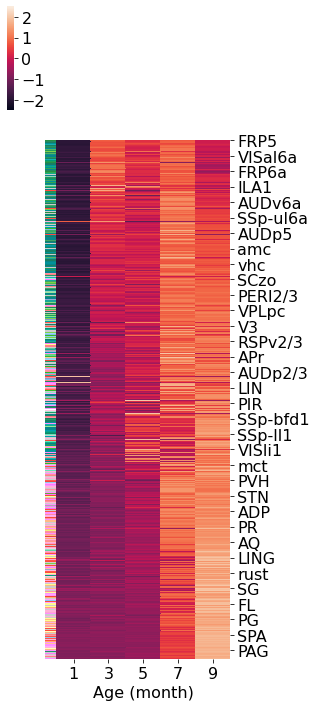

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 欠損値を列ごとの平均で埋める
data_pivot = X.apply(lambda col: col.fillna(col.mean()) if not col.isnull().all() else col.fillna(0))

# Zスコアで正規化し、NaNを0で置換
data_normalized = data_pivot.apply(zscore, axis=1)

# リスト状のデータを各列に展開
data_normalized_df = pd.DataFrame(data_normalized.tolist(), index=data_normalized.index)
# リスト状のデータを各列に展開
#data_normalized_df = pd.DataFrame(data_normalized.values, index=data_normalized.index)

# NaN 値を 0 で置換
data_normalized_df = data_normalized_df.fillna(0)

# adata.obs のインデックスに対応する atlasID を data_normalized_df のインデックスに基づいて再設定
adata.obs['atlasID'] = data_normalized_df.index

# data_normalized_df のインデックスに基づいて、すべての atlasID に対応する dpt_pseudotime を取得
# atlasID に基づいてマージ
merged_data = pd.merge(
    data_normalized_df, 
    adata.obs[['atlasID', 'dpt_pseudotime']], 
    left_index=True, right_on='atlasID', 
    how='left'
)

# pseudotime に基づいて並べ替え
merged_data = merged_data.sort_values(by='dpt_pseudotime')

# 並べ替え後に pseudotime をデータから取り出す
sorted_pseudotime_full = merged_data['dpt_pseudotime']

# 並べ替えられたデータを整理
sorted_data_df = merged_data.drop(columns=['atlasID', 'dpt_pseudotime'])

# データがすべて数値であることを確認
sorted_data_df = sorted_data_df.apply(pd.to_numeric, errors='coerce')

# NaNや無効な値を確認し、すべてを数値に変換
sorted_data_df = sorted_data_df.fillna(0)
sorted_data_df = sorted_data_df.astype(float)

# 元の atlasID を取得し、sorted_data_df のインデックスに再設定する
sorted_data_df.index = merged_data['atlasID']

# acronymのインデックスを取得するために、sorted_data_df.index と data_id['id'] の共通部分のみを使用
acronyms = data_id.set_index('id').loc[sorted_data_df.index, 'acronym']

# colorlist の生成（atlasID と一致させる）
colorlist = []
for atlas_id in sorted_data_df.index:
    if atlas_id in data_GO['id'].values:
        match = data_GO[data_GO['id'] == atlas_id]
        color = (match['R'].values[0] / 255, match['G'].values[0] / 255, match['B'].values[0] / 255)
        colorlist.append(color)

# 色リストがソートされたインデックスに対応しているかを確認
if len(colorlist) == len(sorted_data_df):
    colorlist_671 = colorlist
else:
    print(f"色リストの長さがデータと一致していません。"
          f"colorlist length: {len(colorlist)}, data length: {len(sorted_data_df)}")

# カスタムカラーマップを作成
def create_custom_cmap():
    # Colors: cyan, black, yellow
    colors = ["#00ffff", "#000000", "#ffff00"]
    cmap_name = "custom_cmap"
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)
    return cmap

cmap = create_custom_cmap()

# clustermapプロット
g = sns.clustermap(sorted_data_df,  row_colors=colorlist_671, vmin=-2.5, vmax=2.5, 
                   row_cluster=False, col_cluster=False, figsize=(4, 12))

# x軸のラベルを 1, 3, 5, 7, 9 に変更
g.ax_heatmap.set_xticks(np.arange(len(sorted_data_df.columns))+0.5)  # デフォルトの位置に x の ticks を配置
g.ax_heatmap.set_xticklabels([1, 3, 5, 7, 9], rotation=0)  # ラベルを 1, 3, 5, 7, 9 に変更

# x軸のタイトルを Age (month) に設定
g.ax_heatmap.set_xlabel("Age (month)")#, fontsize=12)
g.ax_heatmap.set_ylabel("", fontsize=12)
# y軸のラベル（region名）を設定
step = 20  # ラベルの間隔を調整
g.ax_heatmap.set_yticks(np.arange(0, len(acronyms), step))
g.ax_heatmap.set_yticklabels(acronyms[::step], rotation=0)

# Adjust layout to avoid overlap and save as a single figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Regional_Abeta_heatmap_after_Pseudotime_reordered.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


/home/mitani/my_env/lib64/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/mitani/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

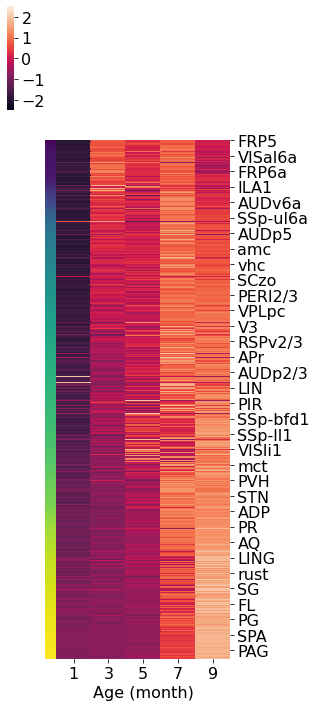

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 欠損値を列ごとの平均で埋める
data_pivot = X.apply(lambda col: col.fillna(col.mean()) if not col.isnull().all() else col.fillna(0))

# Zスコアで正規化し、NaNを0で置換
data_normalized = data_pivot.apply(zscore, axis=1)

# リスト状のデータを各列に展開
data_normalized_df = pd.DataFrame(data_normalized.tolist(), index=data_normalized.index)

# NaN 値を 0 で置換
data_normalized_df = data_normalized_df.fillna(0)

# adata.obs のインデックスに対応する atlasID を data_normalized_df のインデックスに基づいて再設定
adata.obs['atlasID'] = data_normalized_df.index

# data_normalized_df のインデックスに基づいて、すべての atlasID に対応する dpt_pseudotime を取得
# atlasID に基づいてマージ
merged_data = pd.merge(
    data_normalized_df, 
    adata.obs[['atlasID', 'dpt_pseudotime']], 
    left_index=True, right_on='atlasID', 
    how='left'
)

# pseudotime に基づいて並べ替え
merged_data = merged_data.sort_values(by='dpt_pseudotime')

# 並べ替え後に pseudotime をデータから取り出す
sorted_pseudotime_full = merged_data['dpt_pseudotime']

# 並べ替えられたデータを整理
sorted_data_df = merged_data.drop(columns=['atlasID', 'dpt_pseudotime'])

# データがすべて数値であることを確認
sorted_data_df = sorted_data_df.apply(pd.to_numeric, errors='coerce')

# NaNや無効な値を確認し、すべてを数値に変換
sorted_data_df = sorted_data_df.fillna(0)
sorted_data_df = sorted_data_df.astype(float)

# 元の atlasID を取得し、sorted_data_df のインデックスに再設定する
sorted_data_df.index = merged_data['atlasID']

# acronymのインデックスを取得するために、sorted_data_df.index と data_id['id'] の共通部分のみを使用
acronyms = data_id.set_index('id').loc[sorted_data_df.index, 'acronym']

# Viridisカラーマップを使ってpseudotimeの色を設定
viridis = plt.cm.get_cmap('viridis', 256)
norm = plt.Normalize(vmin=0, vmax=1)
pseudotime_colors = viridis(norm(sorted_pseudotime_full))

# プロットをクリアするために挿入
plt.clf()

# clustermapプロット
g = sns.clustermap(sorted_data_df, row_colors=pseudotime_colors, vmin=-2.5, vmax=2.5, 
                   row_cluster=False, col_cluster=False, figsize=(4, 12))

# x軸のラベルを 1, 3, 5, 7, 9 に変更
g.ax_heatmap.set_xticks(np.arange(len(sorted_data_df.columns))+0.5)
g.ax_heatmap.set_xticklabels([1, 3, 5, 7, 9], rotation=0)

# x軸のタイトルを Age (month) に設定
g.ax_heatmap.set_xlabel("Age (month)")#, fontsize=12)
g.ax_heatmap.set_ylabel("", fontsize=12)

# y軸のラベル（region名）を設定
step = 20  # ラベルの間隔を調整
g.ax_heatmap.set_yticks(np.arange(0, len(acronyms), step))
g.ax_heatmap.set_yticklabels(acronyms[::step], rotation=0)

if 1==0:
    # カラーバーの小さな軸を作成
    cbar_ax = g.fig.add_axes([1, 0.4, 0.025, 0.125])  # 左からの位置, 下からの位置, 横幅, 縦幅

    # カラーバーを設定
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=viridis), cax=cbar_ax, label='Pseudotime')

    # 枠線を消す
    cbar.outline.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Regional_Abeta_heatmap_after_Pseudotime_reordered_with_pseudotime_annotation.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


In [15]:
adata.obs

,dpt_pseudotime,atlasID
0,0.815325,1
1,0.054719,2
2,0.381347,6
3,0.929433,7
4,0.194832,9
...,...,...
666,0.937328,60850
667,0.655858,60854
668,0.944422,60858
669,0.752759,60862


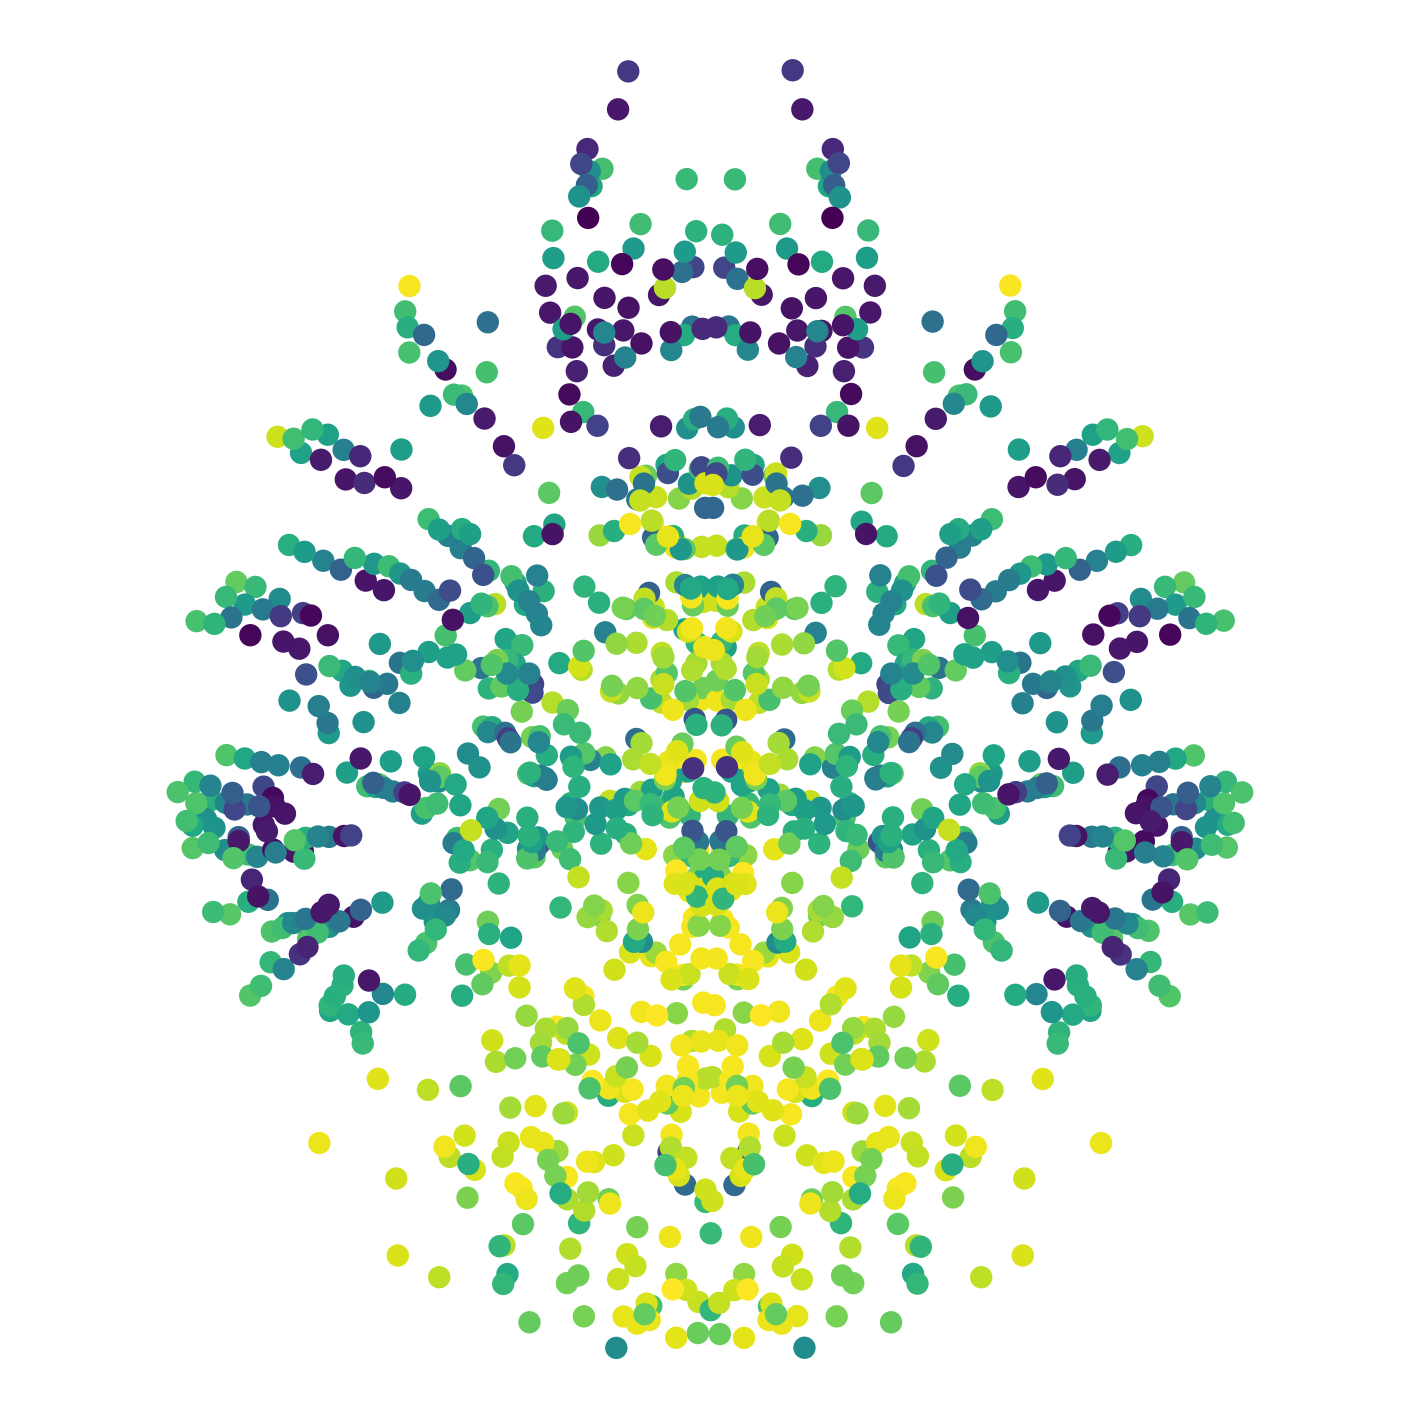

In [215]:
# atlasID が適切に設定されていることを確認する
# adata.obs に atlasID が含まれていることを前提にします
if 'atlasID' not in adata.obs.columns:
    adata.obs['atlasID'] = data_normalized.index

# pseudotime_df を adata.obs から作成し、インデックスを atlasID にする
pseudotime_df = pd.DataFrame(adata.obs[['atlasID', 'dpt_pseudotime']])

# pseudotime_df のインデックスを data_normalized のインデックス（atlasID）に基づいて設定
pseudotime_df = pseudotime_df.set_index('atlasID')

# data_normalized のインデックスに対応して pseudotime の値をマッピング
all_centroids['pseudotime'] = all_centroids['atlasID'].map(pseudotime_df['dpt_pseudotime'])

# pseudotime が NaN の場合は 0 で補完（必要に応じて）
all_centroids['pseudotime'] = all_centroids['pseudotime'].fillna(0)

# viridis_rカラーマップを使用して色情報を生成
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=all_centroids['pseudotime'].min(), vmax=all_centroids['pseudotime'].max())
all_centroids['colors'] = all_centroids['pseudotime'].apply(lambda x: cmap(norm(x)))

# 散布図をプロット
plt.figure(figsize=(20, 20))
sc = plt.scatter(all_centroids['X(um)'], all_centroids['Y(um)'], s=500, c=all_centroids['colors'], edgecolor='none')
#plt.title('Centroids of Left and Right Brain with Pseudotime Coloration')
#plt.xlabel('X (um)')
#plt.ylabel('Y (um)')
plt.axis('equal')  # 軸を等方的にする
plt.gca().invert_yaxis()  # Y軸を反転
plt.gca().spines['top'].set_visible(False)  # 上の軸線を非表示
plt.gca().spines['right'].set_visible(False)  # 右の軸線を非表示
plt.gca().spines['left'].set_visible(False)  # 左の軸線を非表示
plt.gca().spines['bottom'].set_visible(False)  # 下の軸線を非表示
#plt.colorbar(sc, label='Pseudotime from Abeta PCA')  # カラーバーを追加
plt.xticks([])  # X軸の目盛りを非表示
plt.yticks([])  # Y軸の目盛りを非表示

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Whole_brain_plot_of_Regional_Abeta_psedotime.pdf',
            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


In [368]:
all_centroids

,atlasID,X(um),Y(um),Z(um),color,pseudotime,colors
0,1,4706.487793,7498.769531,6676.622070,"(1.0, 0.2980392156862745, 0.24313725490196078)",0.815325,"(0.515992, 0.831158, 0.294279, 1.0)"
1,2,2772.717529,4953.927734,3353.503174,"(0.09411764705882353, 0.5019607843137255, 0.39...",0.054719,"(0.281446, 0.08432, 0.407414, 1.0)"
2,6,3531.550537,6654.017090,4664.744141,"(0.8, 0.8, 0.8)",0.381347,"(0.171176, 0.45253, 0.557965, 1.0)"
3,7,3634.151123,10173.958008,5648.779297,"(1.0, 0.6823529411764706, 0.43529411764705883)",0.929433,"(0.814576, 0.883393, 0.110347, 1.0)"
4,9,4020.127686,6806.070312,1328.008545,"(0.09411764705882353, 0.5019607843137255, 0.39...",0.194832,"(0.257322, 0.25613, 0.526563, 1.0)"
...,...,...,...,...,...,...,...
665,60850,5908.759277,8695.985352,5582.846680,"(1.0, 0.6509803921568628, 1.0)",0.937328,"(0.83527, 0.886029, 0.102646, 1.0)"
666,60854,5817.948730,8835.256836,5106.410156,"(1.0, 0.6509803921568628, 1.0)",0.655858,"(0.19109, 0.708366, 0.482284, 1.0)"
667,60858,5942.808105,8701.027344,5356.506836,"(1.0, 0.6509803921568628, 1.0)",0.944422,"(0.85581, 0.888601, 0.097452, 1.0)"
668,60862,5945.454590,8344.156250,5279.870117,"(1.0, 0.6509803921568628, 1.0)",0.752759,"(0.369214, 0.788888, 0.382914, 1.0)"


In [389]:
label_rows 

,atlasID,X(um),Y(um),Z(um),color,pseudotime,colors
75,147,4731.250000,10698.213867,4292.856934,"(1.0, 0.7647058823529411, 0.5843137254901961)",0.618091,"(0.150148, 0.676631, 0.506589, 1.0)"
196,382,2968.828613,8030.223633,3135.107666,"(0.49411764705882355, 0.8156862745098039, 0.29...",0.561677,"(0.120081, 0.622161, 0.534946, 1.0)"
391,795,5279.304199,9431.977539,3086.885498,"(1.0, 0.5647058823529412, 1.0)",0.989404,"(0.974417, 0.90359, 0.130215, 1.0)"
632,52192,4540.881348,2398.115723,2777.321777,"(0.14901960784313725, 0.5607843137254902, 0.27...",0.000000,"(0.267004, 0.004874, 0.329415, 1.0)"
75,147,6656.140137,10701.753906,4291.228027,"(1.0, 0.7647058823529411, 0.5843137254901961)",0.618091,"(0.150148, 0.676631, 0.506589, 1.0)"
197,382,8423.579102,8031.440430,3137.338379,"(0.49411764705882355, 0.8156862745098039, 0.29...",0.561677,"(0.120081, 0.622161, 0.534946, 1.0)"
392,795,6100.414551,9424.153320,3080.545410,"(1.0, 0.5647058823529412, 1.0)",0.989404,"(0.974417, 0.90359, 0.130215, 1.0)"
633,52192,6850.609863,2397.391602,2776.727539,"(0.14901960784313725, 0.5607843137254902, 0.27...",0.000000,"(0.267004, 0.004874, 0.329415, 1.0)"


ENTl5
ACAd2/3
SNr
PB
FRP5
ENTl5
ACAd2/3
SNr
PB
FRP5


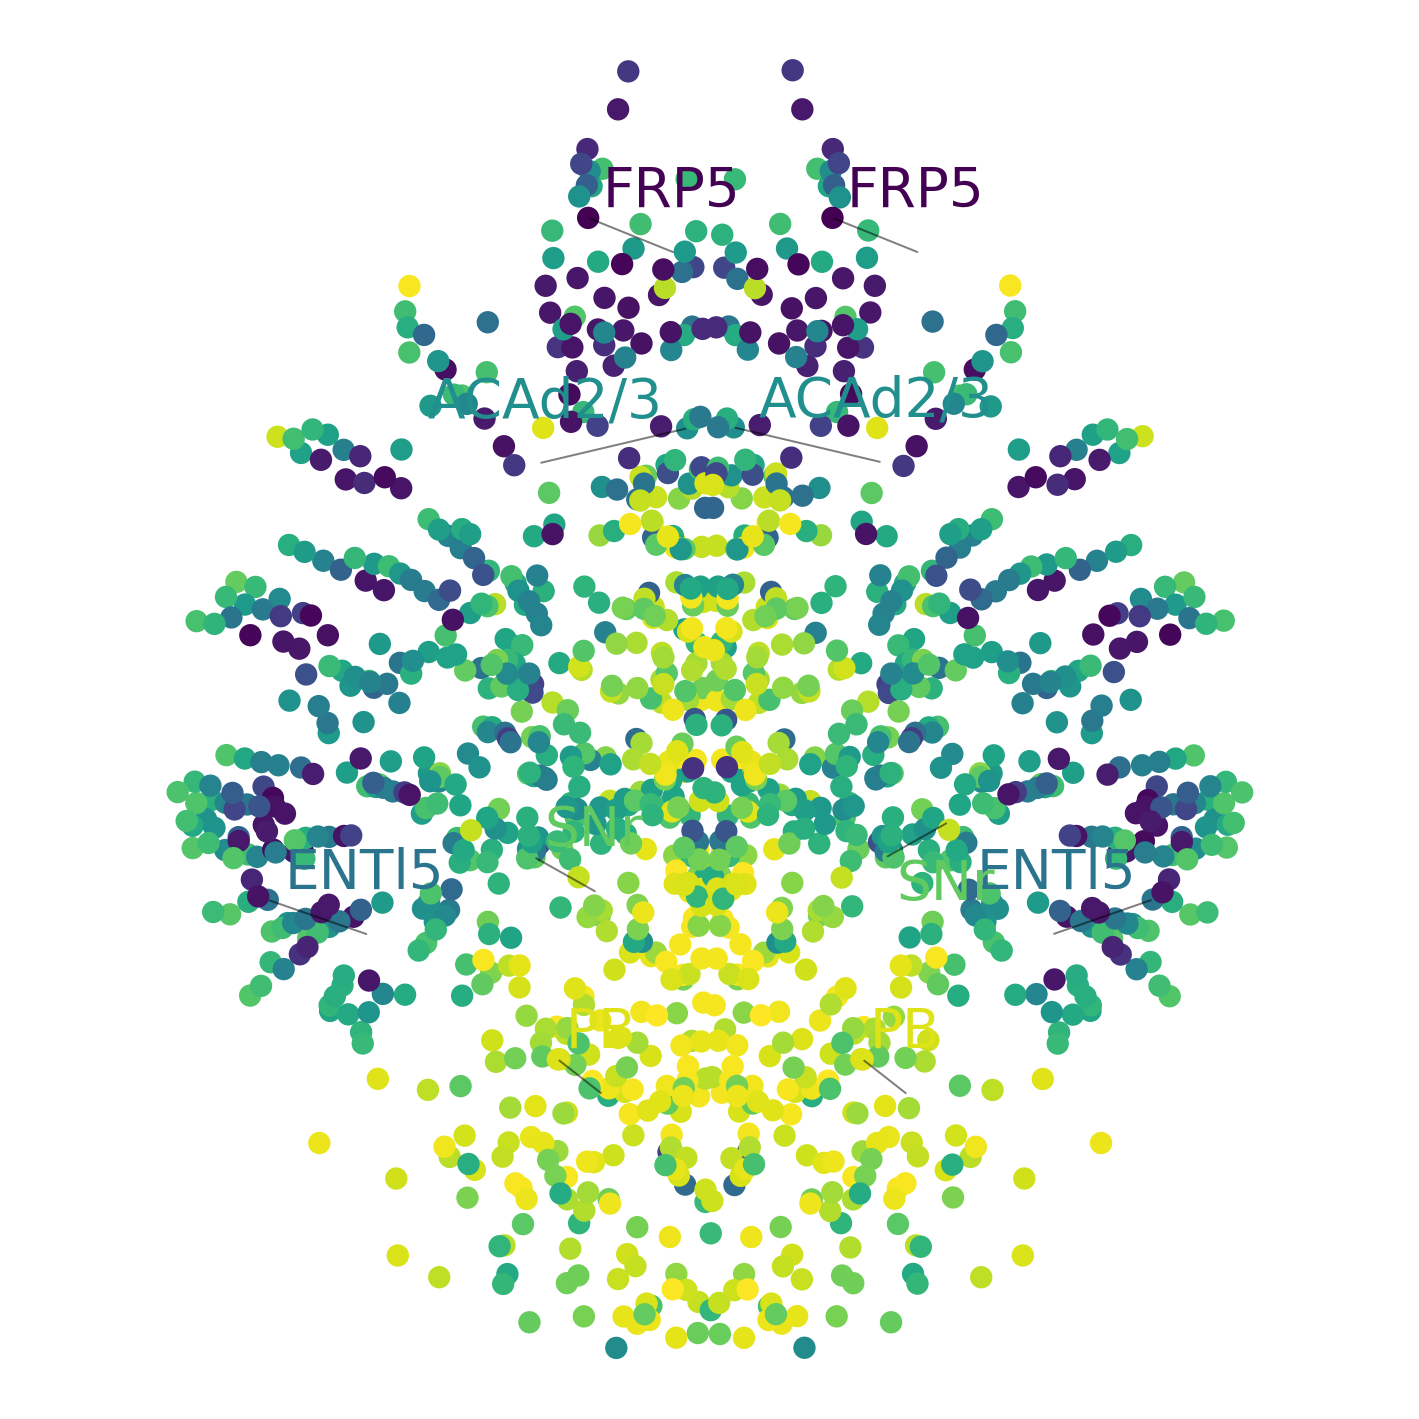

In [424]:
# param_anaから対応するacronym名を取得する関数
def get_acronym_by_id(atlas_id, param_ana):
    for el in param_ana:
        if el['id'] == atlas_id:
            return el['acronym']
    return None  # 見つからなかった場合

# 指定したregionに対応するatlasIDを取得
regions_to_label = [
    get_region_id('FRP5', param_ana),
    get_region_id('ENTl5', param_ana),
    get_region_id('ACAd2/3', param_ana),
    get_region_id('SNr', param_ana),
    get_region_id('PB', param_ana)
]

# 特定のacronymをラベルとして描画したいregionsに対応するacronym名を取得
label_acronyms = [
    get_acronym_by_id(get_region_id('FRP5', param_ana), param_ana),
    get_acronym_by_id(get_region_id('ENTl5', param_ana), param_ana),
    get_acronym_by_id(get_region_id('ACAd2/3', param_ana), param_ana),
    get_acronym_by_id(get_region_id('SNr', param_ana), param_ana),
    get_acronym_by_id(get_region_id('PB', param_ana), param_ana)
]

# regions_to_labelをacronymに変換（atlasIDではなくregion名でフィルタ）
label_rows = all_centroids[all_centroids['atlasID'].isin(regions_to_label)]

# 散布図をプロット
plt.figure(figsize=(20, 20))
sc = plt.scatter(all_centroids['X(um)'], all_centroids['Y(um)'], s=500, c=all_centroids['colors'], edgecolor='none')

# 特定のregionのテキストをacronymで追加
texts = []
for i, row in label_rows.iterrows():
    acronym = get_acronym_by_id(row['atlasID'], param_ana)  # atlasIDからacronymを取得
    print(acronym)
    if acronym is not None:
        texts.append(plt.text(row['X(um)'], row['Y(um)'], acronym,  # acronymを描画
                              ha='center', va='center', fontsize=55, color=row['colors'], fontweight='regular'))

# adjust_textでテキストの重なりを調整
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color=(0, 0, 0), alpha=0.5, linewidth=2),
            expand_points=(1.2, 1.2),  # ポイントからの距離を微調整
            expand_text=(1., 1.),    # テキスト間の距離を微調整
            force_text=(1., 1.),     # テキストを動かす力を減らす
            force_points=(1., 0.)    # ポイントを動かす力を減らす
           )

# 軸の設定
plt.axis('equal')
plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Whole_brain_plot_of_Regional_Abeta_psedotime_with_arrow.pdf',
            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


In [370]:
print(all_centroids.columns)


Index(['atlasID', 'X(um)', 'Y(um)', 'Z(um)', 'color', 'pseudotime', 'colors'], dtype='object')


In [ ]:
#Fig.3g Thal phase

In [228]:
# 下記は一部のidだけが対象
dir= "/export3/Imaging/Axial/Neurorology/8w_B6JWT_atlas_1_2022_0924_1847/"
dir_ana=dir+"Allen_graph.json"

with open(dir_ana) as f:
    param_ana = json.load(f)

In [229]:
param_ana

[{'rgb_triplet': [255, 255, 255],
  'graph_id': 1,
  'name': 'root',
  'acronym': 'root',
  'graph_order': 0,
  'structure_id_path': [997],
  'structure_set_ids': [],
  'id': 997},
 {'rgb_triplet': [191, 218, 227],
  'graph_id': 1,
  'name': 'Basic cell groups and regions',
  'acronym': 'grey',
  'graph_order': 1,
  'structure_id_path': [997, 8],
  'structure_set_ids': [112905828,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'id': 8},
 {'rgb_triplet': [176, 240, 255],
  'graph_id': 1,
  'name': 'Cerebrum',
  'acronym': 'CH',
  'graph_order': 2,
  'structure_id_path': [997, 8, 567],
  'structure_set_ids': [112905828,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'id': 567},
 {'rgb_triplet': [176, 255, 184],
  'graph_id': 1,
  'name': 'Cerebral cortex',
  'acronym': 'CTX',
  'graph_order': 3,
  'structure_id_path': [997, 8, 567, 688],
  'structure_set_ids': [112905828,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'id': 688},
 

In [227]:
# Thal phase regionの定義
Thal_phase_1 = ["Isocortex",]
Thal_phase_2 = ["CA1",
                "ENTl", "ENTm"]
Thal_phase_3 = ["ACA","RSP", 
                "LA", "BLA", "BMA","PA", "CEA", "MEA", "COA",
               "DG", 
               "PRE","POST",
               "TH",
               "CP", "ACB",
               "HY", 
                "SI", "MA", "NDB"]
Thal_phase_4 = ["PAG",
                "SCs","SCm", 
                "RN",
               "IO",
               "SNr", "SNc"]
Thal_phase_5 = ["GRN", "IRN", "PARN",
               "CBX",
               "PRNr","PRNc",
               "RAMb",
               "LC",
               "PB",
               "TRN",
               "DTN",
               "PG",]

In [231]:
# Combine all Thal phases
all_thal_phases = Thal_phase_1 + Thal_phase_2 + Thal_phase_3 + Thal_phase_4 + Thal_phase_5

# Function to get all subregions under a specific region
def get_subregions(region_name, param_ana):
    subregions = []
    for el in param_ana:
        if el['acronym'] == region_name:
            parent_id = el['id']
            subregions.append({'acronym': el['acronym'], 'structure_id': el['id']})
            for sub_el in param_ana:
                # Check if the structure_id_path contains the parent_id (i.e., it's a child)
                if parent_id in sub_el['structure_id_path']:
                    subregions.append({'acronym': sub_el['acronym'], 'structure_id': sub_el['id']})
    return subregions

# Get all subregions for each Thal phase region
thal_phase_regions = {}

for region in all_thal_phases:
    subregions = get_subregions(region, param_ana)
    thal_phase_regions[region] = subregions

# Output the result
for phase, regions in thal_phase_regions.items():
    print(f"Regions under {phase}:")
    for region in regions:
        print(f"  Acronym: {region['acronym']}, Structure ID: {region['structure_id']}")


Regions under Isocortex:
  Acronym: Isocortex, Structure ID: 315
  Acronym: Isocortex, Structure ID: 315
  Acronym: FRP, Structure ID: 184
  Acronym: FRP1, Structure ID: 68
  Acronym: FRP2/3, Structure ID: 667
  Acronym: FRP5, Structure ID: 52192
  Acronym: FRP6a, Structure ID: 52196
  Acronym: FRP6b, Structure ID: 52264
  Acronym: MO, Structure ID: 500
  Acronym: MO1, Structure ID: 107
  Acronym: MO2/3, Structure ID: 219
  Acronym: MO5, Structure ID: 299
  Acronym: MO6a, Structure ID: 644
  Acronym: MO6b, Structure ID: 947
  Acronym: MOp, Structure ID: 985
  Acronym: MOp1, Structure ID: 320
  Acronym: MOp2/3, Structure ID: 943
  Acronym: MOp5, Structure ID: 648
  Acronym: MOp6a, Structure ID: 844
  Acronym: MOp6b, Structure ID: 882
  Acronym: MOs, Structure ID: 993
  Acronym: MOs1, Structure ID: 656
  Acronym: MOs2/3, Structure ID: 962
  Acronym: MOs5, Structure ID: 767
  Acronym: MOs6a, Structure ID: 1021
  Acronym: MOs6b, Structure ID: 1085
  Acronym: SS, Structure ID: 453
  Acronym

In [248]:
from scipy.stats import spearmanr

# Thal phaseの順序を表す数値を定義
thal_phase_order_numeric = [1, 2, 3, 4, 5]

# thal_phase_means_dfのpseudotimeの平均値を取得
thal_phase_pseudotime_values = thal_phase_means_df['mean_dpt_pseudotime'].values

# Spearman相関を計算
corr, p_value = spearmanr(thal_phase_order_numeric, thal_phase_pseudotime_values)

# 結果を表示
print(f"Spearman Correlation for pseudotime: {corr}")
print(f"P-value for pseudotime: {p_value}")


Spearman Correlation for pseudotime: 0.9999999999999999
P-value for pseudotime: 1.4042654220543672e-24


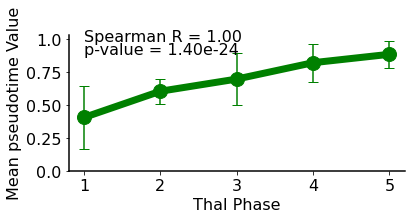

In [367]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib

# グラフの設定
matplotlib.rcParams['pdf.use14corefonts'] = True
plt.rcParams['font.size'] = 16

# Thal phaseの定義
thal_phases = {
    'Thal_phase_1': ["Isocortex"],
    'Thal_phase_2': ["CA1", "ENTl", "ENTm"],
    'Thal_phase_3': ["ACA", "RSP", "LA", "BLA", "BMA", "PA", "CEA", "MEA", "COA", "DG", "PRE", "POST", "TH", "CP", "ACB", "HY", "SI", "MA", "NDB"],
    'Thal_phase_4': ["PAG", "SCs", "SCm", "RN", "IO", "SNr", "SNc"],
    'Thal_phase_5': ["GRN", "IRN", "PARN", "CBX", "PRNr", "PRNc", "RAMb", "LC", "PB", "TRN", "DTN", "PG"]
}

# param_anaからサブ領域を取得する関数
def get_subregions(region_name, param_ana):
    subregions = []
    for el in param_ana:
        if el['acronym'] == region_name:
            parent_id = el['id']
            subregions.append({'acronym': el['acronym'], 'structure_id': el['id']})
            for sub_el in param_ana:
                if parent_id in sub_el['structure_id_path']:  # 親領域かどうかを確認
                    subregions.append({'acronym': sub_el['acronym'], 'structure_id': sub_el['id']})
    return subregions

# Thal phaseごとのサブ領域を取得
thal_phase_regions = {}

for phase, regions in thal_phases.items():
    subregions = []
    for region in regions:
        subregions.extend(get_subregions(region, param_ana))
    thal_phase_regions[phase] = subregions

# Thal phaseごとのatlasIDリストを作成
thal_phase_atlas_ids = {}
for phase, regions in thal_phase_regions.items():
    atlas_ids = [region['structure_id'] for region in regions]
    thal_phase_atlas_ids[phase] = atlas_ids

# Thal phaseごとのdpt_pseudotimeの平均値と標準偏差を計算
thal_phase_means = {}
thal_phase_stds = {}  # 標準偏差を保存する辞書

for phase, atlas_ids in thal_phase_atlas_ids.items():
    phase_data = merged_data[merged_data['atlasID'].isin(atlas_ids)]
    if not phase_data.empty:
        thal_phase_means[phase] = phase_data['dpt_pseudotime'].mean()
        thal_phase_stds[phase] = phase_data['dpt_pseudotime'].std()  # 標準偏差を計算
    else:
        thal_phase_means[phase] = 0  # 該当データがない場合
        thal_phase_stds[phase] = 0

# 平均値と標準偏差をDataFrameに変換
thal_phase_means_df = pd.DataFrame(list(thal_phase_means.items()), columns=['Thal_phase', 'mean_dpt_pseudotime'])
thal_phase_stds_df = pd.DataFrame(list(thal_phase_stds.items()), columns=['Thal_phase', 'std_dpt_pseudotime'])

# Thal phaseを数値に変換
thal_phase_means_df['Thal_phase_numeric'] = [1, 2, 3, 4, 5]  # Thal phaseを1, 2, 3, 4, 5として扱う
thal_phase_stds_df['Thal_phase_numeric'] = [1, 2, 3, 4, 5]

# Spearman相関を計算
corr, p_value = spearmanr(thal_phase_means_df['Thal_phase_numeric'], thal_phase_means_df['mean_dpt_pseudotime'])

# グラフの描画
plt.figure(figsize=(6, 3))

# 折れ線グラフを作成（折れ線）
plt.plot(thal_phase_means_df['Thal_phase_numeric'], thal_phase_means_df['mean_dpt_pseudotime'], color='green', linestyle='-', linewidth=7)

# エラーバー付きのデータポイントを作成
plt.errorbar(thal_phase_means_df['Thal_phase_numeric'], thal_phase_means_df['mean_dpt_pseudotime'],
             yerr=thal_phase_stds_df['std_dpt_pseudotime'], fmt='o', color='green', markersize=14, capsize=5)

# グラフの設定
plt.xlabel('Thal Phase')
plt.ylabel('Mean pseudotime Value')

# スパインの非表示設定
ax = plt.gca()  # 現在の軸を取得
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# x軸の目盛りを1, 2, 3, 4, 5に設定
plt.xticks([1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'])
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], labels=['0.0', '0.25', '0.50', '0.75',  '1.0'])

# Spearman相関の結果をグラフの左上に表示
plt.text(1, max(thal_phase_means_df['mean_dpt_pseudotime']) + 0.1, f"Spearman R = {corr:.2f}", ha='left')
plt.text(1, max(thal_phase_means_df['mean_dpt_pseudotime']) + 0.0, f"p-value = {p_value:.2e}", ha='left')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Thal_phase_vs_pseudotime_graph.pdf',
            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


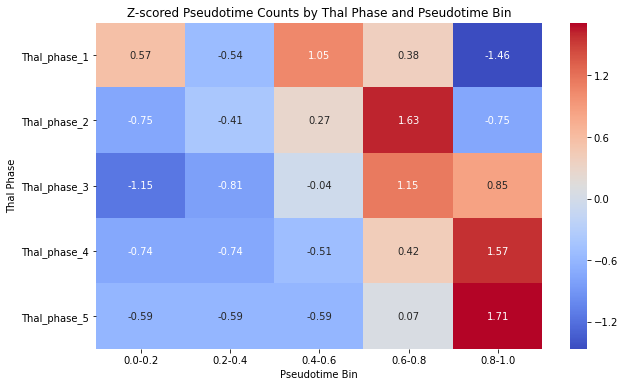

In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Thal phaseの定義
thal_phases = {
    'Thal_phase_1': ["Isocortex"],
    'Thal_phase_2': ["CA1", "ENTl", "ENTm"],
    'Thal_phase_3': ["ACA", "RSP", "LA", "BLA", "BMA", "PA", "CEA", "MEA", "COA", "DG", "PRE", "POST", "TH", "CP", "ACB", "HY", "SI", "MA", "NDB"],
    'Thal_phase_4': ["PAG", "SCs", "SCm", "RN", "IO", "SNr", "SNc"],
    'Thal_phase_5': ["GRN", "IRN", "PARN", "CBX", "PRNr", "PRNc", "RAMb", "LC", "PB", "TRN", "DTN", "PG"]
}

# dpt_pseudotimeの列名
pseudotime_column = 'dpt_pseudotime'

# param_anaからサブ領域を取得する関数
def get_subregions(region_name, param_ana):
    subregions = []
    for el in param_ana:
        if el['acronym'] == region_name:
            parent_id = el['id']
            subregions.append({'acronym': el['acronym'], 'structure_id': el['id']})
            for sub_el in param_ana:
                if parent_id in sub_el['structure_id_path']:  # 親領域かどうかを確認
                    subregions.append({'acronym': sub_el['acronym'], 'structure_id': sub_el['id']})
    return subregions

# Thal phaseごとのサブ領域を取得
thal_phase_regions = {}

for phase, regions in thal_phases.items():
    subregions = []
    for region in regions:
        subregions.extend(get_subregions(region, param_ana))
    thal_phase_regions[phase] = subregions

# Thal phaseごとのatlasIDリストを作成
thal_phase_atlas_ids = {}
for phase, regions in thal_phase_regions.items():
    atlas_ids = [region['structure_id'] for region in regions]
    thal_phase_atlas_ids[phase] = atlas_ids

# Thal phaseごとのpseudotimeカウントを保存するDataFrameを作成
thal_phase_pseudotime_counts = pd.DataFrame(0, index=thal_phases.keys(), columns=['0.0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'])

# 各Thal phaseごとに、pseudotimeを5つのbinに分けてカウント
for phase, atlas_ids in thal_phase_atlas_ids.items():
    pseudotime_values = merged_data.loc[merged_data['atlasID'].isin(atlas_ids), pseudotime_column].dropna()
    
    # 各binに分類してカウント
    thal_phase_pseudotime_counts.loc[phase, '0.0-0.2'] = ((pseudotime_values >= 0.0) & (pseudotime_values < 0.2)).sum()
    thal_phase_pseudotime_counts.loc[phase, '0.2-0.4'] = ((pseudotime_values >= 0.2) & (pseudotime_values < 0.4)).sum()
    thal_phase_pseudotime_counts.loc[phase, '0.4-0.6'] = ((pseudotime_values >= 0.4) & (pseudotime_values < 0.6)).sum()
    thal_phase_pseudotime_counts.loc[phase, '0.6-0.8'] = ((pseudotime_values >= 0.6) & (pseudotime_values < 0.8)).sum()
    thal_phase_pseudotime_counts.loc[phase, '0.8-1.0'] = ((pseudotime_values >= 0.8) & (pseudotime_values <= 1.0)).sum()

# 各binごとにZスコアを計算（x軸方向に正規化）
thal_phase_pseudotime_z = thal_phase_pseudotime_counts.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# ヒートマップを作成
plt.figure(figsize=(10, 6))
sns.heatmap(thal_phase_pseudotime_z, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')  # fmt='.2f'で小数点2桁表示に設定
plt.title('Z-scored Pseudotime Counts by Thal Phase and Pseudotime Bin')
plt.xlabel('Pseudotime Bin')
plt.ylabel('Thal Phase')
plt.show()


In [264]:
# cellome_onset DataFrameの作成
ids = data_GO["id"].astype(int).unique()
cellome_onset = pd.DataFrame(index=ids)

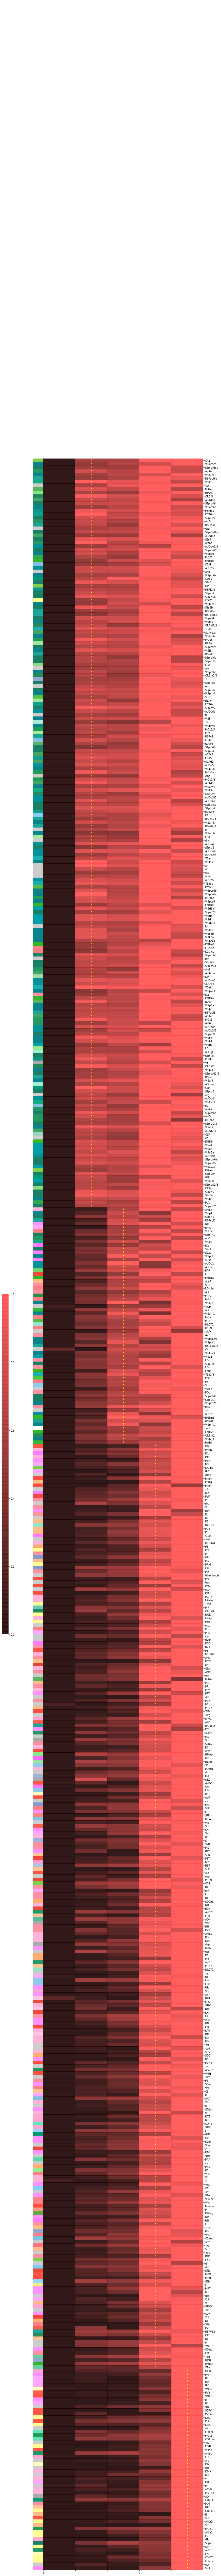

In [265]:
# Abeta increase
# APP only

import pandas as pd

# CSVファイルを読み込む
X = pd.read_csv('/export3/Imaging/ds4_Data4/Region/APP_raw_value_regions_Abeta_increase.csv', index_col='atlasID')
X_all = pd.read_csv('/export3/Imaging/ds4_Data4/Region/APP_raw_value_regions_Abeta_all.csv', index_col='atlasID')
#X = pd.read_csv('/export3/Imaging/ds4_Data4/Region/APP_raw_value_regions_lire_ver_Abeta_increase_random_slice_1.csv', index_col='atlasID')

category = "APP_specific_Abeta_increase_onset(m)"

import ruptures as rpt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from matplotlib import rcParams

#data_GO = pd.read_csv(filepath_or_buffer="/data4/ds1_Imaging3/atlas_for_fig/GOvsID_6region_removed.csv", encoding="ms932", sep=",")

ids = data_GO["id"].astype(int).unique()

# フォントをDejaVu Sansに設定
rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10  # Adjust the size as needed

months = np.array([1, 3, 5, 7, 9])  # 月数をインデックスとして使用

# Function to detect change points in each row using ruptures
def detect_change_points(data):
    change_points = []
    for index, row in data.iterrows():
        # Extract the values and convert to numpy array
        values = row.values.astype(float)
        # Create a change point detection model instance
        model = "l2"  # Using L2 norm (least squares)
        algo = rpt.Binseg(model=model, min_size=1, jump=1).fit(values)
        # Detect change point
        result = algo.predict(n_bkps=1)
        change_points.append(months[result[:-1]][0])
    return change_points

# Run the change point detection function
data = X.copy()
# Detect change points
change_points = detect_change_points(data)

# データフレームに変化点を追加
data['Change Points'] = change_points


cellome_onset[category] = np.nan  # 初期値としてNaNを設定

# 存在する変化点をcellome_onsetに追加
for atlas_id, change_point in zip(data.index, change_points):
    if atlas_id in cellome_onset.index:
        cellome_onset.at[atlas_id, category] = change_point

for atlas_id in ids:
    if atlas_id in X_all.index:
        cellome_onset.at[atlas_id, "1m_" + category] = X_all.loc[atlas_id, "APP_1m"]
        cellome_onset.at[atlas_id, "3m_" + category] = X_all.loc[atlas_id, "APP_3m"]
        cellome_onset.at[atlas_id, "5m_" + category] = X_all.loc[atlas_id, "APP_5m"]
        cellome_onset.at[atlas_id, "7m_" + category] = X_all.loc[atlas_id, "APP_7m"]
        cellome_onset.at[atlas_id, "9m_" + category] = X_all.loc[atlas_id, "APP_9m"]  

# カスタムカラーマップの作成
def create_custom_cmap():
    colors = [(0.1, 0.0, 0.0, 0.9),  (1, 0.3, 0.3, 0.90)]
    cmap_name = "custom_cmap"
    # Create a colormap with interpolation between specified colors
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)
    return cmap

# Using the new custom colormap
cmap = create_custom_cmap()

# 行ごとに正規化
normalized_data = data.iloc[:, :-1].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# 行ごとに変化点月齢を強調するためのデータフレームを作成
stars = data.iloc[:, :-1].copy().astype(str)
stars[:] = ''  # 全てのセルを空文字列に設定
for i, cp in enumerate(change_points):
    month_col_cp = f'APP_{cp}m'
    if month_col_cp in stars.columns:
        stars.at[data.index[i], month_col_cp] = '*'

# 変化点でソート
sorted_indices = np.argsort(change_points)
sorted_normalized_data = normalized_data.iloc[sorted_indices]
sorted_stars = stars.iloc[sorted_indices]

# acronymのインデックスを追加
acronyms = data_id.set_index('id').loc[sorted_normalized_data.index, 'acronym']

colorlist = []
colorlist_671 = []

for atlas_id in sorted_normalized_data.index:
    for i in range(671):
        if data_GO["id"].values[i] == atlas_id:
            colorlist.append((data_GO["R"].values[i]/255, data_GO["G"].values[i]/255, data_GO["B"].values[i]/255))
    colorlist_671 = colorlist

# プロット
height = (17/55) * len(X)
g = sns.clustermap(sorted_normalized_data, cmap=cmap, row_colors=colorlist_671, vmin=0, vmax=1, row_cluster=False, col_cluster=False, annot=sorted_stars, fmt='', annot_kws={"size": 10, "weight": "bold", "color": "yellow"}, figsize=(12, height))
# 行ラベルをacronymに置き換え
g.ax_heatmap.set_yticklabels(acronyms)
g.ax_heatmap.yaxis.set_tick_params(rotation=0)
# x軸ラベルを変更
new_labels = ['1', '3', '5', '7', '9']
g.ax_heatmap.set_xticks(np.arange(len(new_labels)))  # Ensure there are correct number of ticks
g.ax_heatmap.set_xticklabels(new_labels)

# 不要な右端の縦軸ラベルを削除
g.ax_heatmap.set_ylabel('')

g.cax.set_position([.0, .4, .03, .1])  # [left, bottom, width, height]

plt.show()


In [293]:
from scipy.stats import spearmanr

# Thal phaseの順序を表す数値を定義
thal_phase_order_numeric = [1, 2, 3, 4, 5]

# thal_phase_onset_means_dfの平均値を取得
thal_phase_onset_values = thal_phase_onset_means_df['mean_onset'].values

# Spearman相関を計算
corr, p_value = spearmanr(thal_phase_order_numeric, thal_phase_onset_values)

# 結果を表示
print(f"Spearman Correlation: {corr}")
print(f"P-value: {p_value}")


Spearman Correlation: 0.9999999999999999
P-value: 1.4042654220543672e-24


In [294]:
thal_phase_onset_means_df['mean_onset']

Thal_phase
Thal_phase_1    3.650246
Thal_phase_2    4.090909
Thal_phase_3    6.021898
Thal_phase_4    6.857143
Thal_phase_5    7.615385
Name: mean_onset, dtype: float64

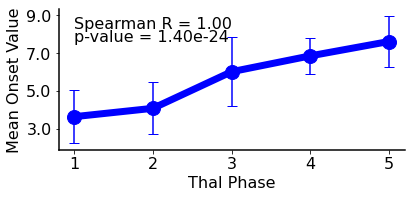

In [366]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
plt.rcParams['font.size'] = 16

# Thal phaseの定義
thal_phases = {
    'Thal_phase_1': ["Isocortex"],
    'Thal_phase_2': ["CA1", "ENTl", "ENTm"],
    'Thal_phase_3': ["ACA", "RSP", "LA", "BLA", "BMA", "PA", "CEA", "MEA", "COA", "DG", "PRE", "POST", "TH", "CP", "ACB", "HY", "SI", "MA", "NDB"],
    'Thal_phase_4': ["PAG", "SCs", "SCm", "RN", "IO", "SNr", "SNc"],
    'Thal_phase_5': ["GRN", "IRN", "PARN", "CBX", "PRNr", "PRNc", "RAMb", "LC", "PB", "TRN", "DTN", "PG"]
}

# param_anaからサブ領域を取得する関数
def get_subregions(region_name, param_ana):
    subregions = []
    for el in param_ana:
        if el['acronym'] == region_name:
            parent_id = el['id']
            subregions.append({'acronym': el['acronym'], 'structure_id': el['id']})
            for sub_el in param_ana:
                if parent_id in sub_el['structure_id_path']:  # 親領域かどうかを確認
                    subregions.append({'acronym': sub_el['acronym'], 'structure_id': sub_el['id']})
    return subregions

# Thal phaseごとのサブ領域を取得
thal_phase_regions = {}

for phase, regions in thal_phases.items():
    subregions = []
    for region in regions:
        subregions.extend(get_subregions(region, param_ana))
    thal_phase_regions[phase] = subregions

# Thal phaseごとのatlasIDリストを作成
thal_phase_atlas_ids = {}
for phase, regions in thal_phase_regions.items():
    atlas_ids = [region['structure_id'] for region in regions]
    thal_phase_atlas_ids[phase] = atlas_ids

# Thal phaseごとのonsetの平均値と標準偏差を計算
thal_phase_onset_means = {}
thal_phase_onset_stds = {}  # 標準偏差を保存する辞書

for phase, atlas_ids in thal_phase_atlas_ids.items():
    onset_values = cellome_onset.loc[cellome_onset.index.isin(atlas_ids), category].dropna()
    if not onset_values.empty:
        thal_phase_onset_means[phase] = onset_values.mean()
        thal_phase_onset_stds[phase] = onset_values.std()  # 標準偏差を計算
    else:
        thal_phase_onset_means[phase] = np.nan  # データが存在しない場合
        thal_phase_onset_stds[phase] = np.nan  # 標準偏差もなし

# 平均値と標準偏差をDataFrameに変換
thal_phase_onset_means_df = pd.DataFrame(list(thal_phase_onset_means.items()), columns=['Thal_phase', 'mean_onset'])
thal_phase_onset_stds_df = pd.DataFrame(list(thal_phase_onset_stds.items()), columns=['Thal_phase', 'std_onset'])

# Thal phaseを数値に変換
thal_phase_onset_means_df['Thal_phase_numeric'] = [1, 2, 3, 4, 5]  # Thal phaseを1, 2, 3, 4, 5として扱う
thal_phase_onset_stds_df['Thal_phase_numeric'] = [1, 2, 3, 4, 5]

# Spearman相関を計算
corr, p_value = spearmanr(thal_phase_onset_means_df['Thal_phase_numeric'], thal_phase_onset_means_df['mean_onset'])

# グラフの描画
plt.figure(figsize=(6, 3))

# 折れ線グラフを作成（折れ線）
plt.plot(thal_phase_onset_means_df['Thal_phase_numeric'], thal_phase_onset_means_df['mean_onset'], color='blue', linestyle='-', linewidth=7)

# エラーバー付きのデータポイントを作成
plt.errorbar(thal_phase_onset_means_df['Thal_phase_numeric'], thal_phase_onset_means_df['mean_onset'],
             yerr=thal_phase_onset_stds_df['std_onset'], fmt='o', color='blue', markersize=14, capsize=5)

# グラフの設定
plt.xlabel('Thal Phase')
plt.ylabel('Mean Onset Value')

# スパインの非表示設定
ax = plt.gca()  # 現在の軸を取得
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# x軸の目盛りを1, 2, 3, 4, 5に設定
plt.xticks([1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'])
plt.yticks([3.0, 5.0, 7.0, 9.0], labels=['3.0', '5.0', '7.0', '9.0'])

# Spearman相関の結果をグラフの左上に表示
plt.text(1, max(thal_phase_onset_means_df['mean_onset']) + 0.7, f"Spearman R = {corr:.2f}", ha='left')
plt.text(1, max(thal_phase_onset_means_df['mean_onset']) + 0.0, f"p-value = {p_value:.2e}", ha='left')

# グラフの表示
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure as a PDF with transparent background
plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.3/Thal_phase_vs_onset_graph.pdf',
            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


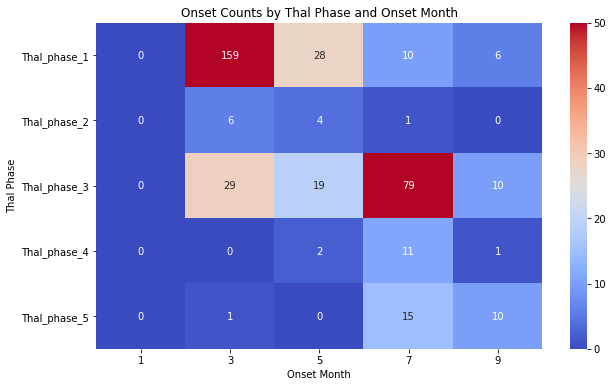

In [271]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Thal phaseの定義
thal_phases = {
    'Thal_phase_1': ["Isocortex"],
    'Thal_phase_2': ["CA1", "ENTl", "ENTm"],
    'Thal_phase_3': ["ACA", "RSP", "LA", "BLA", "BMA", "PA", "CEA", "MEA", "COA", "DG", "PRE", "POST", "TH", "CP", "ACB", "HY", "SI", "MA", "NDB"],
    'Thal_phase_4': ["PAG", "SCs", "SCm", "RN", "IO", "SNr", "SNc"],
    'Thal_phase_5': ["GRN", "IRN", "PARN", "CBX", "PRNr", "PRNc", "RAMb", "LC", "PB", "TRN", "DTN", "PG"]
}

# onset列の指定 (Abeta volumeではなくonset列)
onset_column = 'APP_specific_Abeta_increase_onset(m)'

# param_anaからサブ領域を取得する関数
def get_subregions(region_name, param_ana):
    subregions = []
    for el in param_ana:
        if el['acronym'] == region_name:
            parent_id = el['id']
            subregions.append({'acronym': el['acronym'], 'structure_id': el['id']})
            for sub_el in param_ana:
                if parent_id in sub_el['structure_id_path']:  # 親領域かどうかを確認
                    subregions.append({'acronym': sub_el['acronym'], 'structure_id': sub_el['id']})
    return subregions

# Thal phaseごとのサブ領域を取得
thal_phase_regions = {}

for phase, regions in thal_phases.items():
    subregions = []
    for region in regions:
        subregions.extend(get_subregions(region, param_ana))
    thal_phase_regions[phase] = subregions

# Thal phaseごとのatlasIDリストを作成
thal_phase_atlas_ids = {}
for phase, regions in thal_phase_regions.items():
    atlas_ids = [region['structure_id'] for region in regions]
    thal_phase_atlas_ids[phase] = atlas_ids

# Thal phaseごとのonsetカウントを保存するDataFrameを作成
thal_phase_onset_counts = pd.DataFrame(0, index=thal_phases.keys(), columns=[1, 3, 5, 7, 9])

# 各Thal phaseごとに、各regionがどのonsetに属するかをカウント
for phase, atlas_ids in thal_phase_atlas_ids.items():
    onset_values = cellome_onset.loc[cellome_onset.index.isin(atlas_ids), onset_column].dropna()
    
    # 各onsetの値が1, 3, 5, 7, 9に該当するものをカウント
    for onset in onset_values:
        if onset in [1, 3, 5, 7, 9]:
            thal_phase_onset_counts.loc[phase, onset] += 1

# ヒートマップを作成
plt.figure(figsize=(10, 6))
sns.heatmap(thal_phase_onset_counts, annot=True, cmap='coolwarm', cbar=True, fmt='d', vmax=50, vmin = 0)  # fmt='d'で整数表示に設定
plt.title('Onset Counts by Thal Phase and Onset Month')
plt.xlabel('Onset Month')
plt.ylabel('Thal Phase')
plt.show()


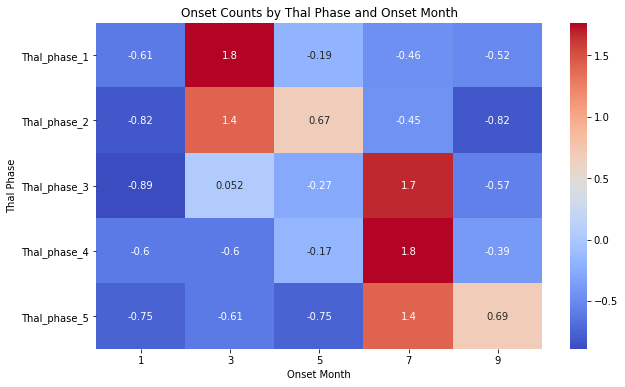

In [278]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Thal phaseの定義
thal_phases = {
    'Thal_phase_1': ["Isocortex"],
    'Thal_phase_2': ["CA1", "ENTl", "ENTm"],
    'Thal_phase_3': ["ACA", "RSP", "LA", "BLA", "BMA", "PA", "CEA", "MEA", "COA", "DG", "PRE", "POST", "TH", "CP", "ACB", "HY", "SI", "MA", "NDB"],
    'Thal_phase_4': ["PAG", "SCs", "SCm", "RN", "IO", "SNr", "SNc"],
    'Thal_phase_5': ["GRN", "IRN", "PARN", "CBX", "PRNr", "PRNc", "RAMb", "LC", "PB", "TRN", "DTN", "PG"]
}

# onset列の指定 (Abeta volumeではなくonset列)
onset_column = 'APP_specific_Abeta_increase_onset(m)'

# param_anaからサブ領域を取得する関数
def get_subregions(region_name, param_ana):
    subregions = []
    for el in param_ana:
        if el['acronym'] == region_name:
            parent_id = el['id']
            subregions.append({'acronym': el['acronym'], 'structure_id': el['id']})
            for sub_el in param_ana:
                if parent_id in sub_el['structure_id_path']:  # 親領域かどうかを確認
                    subregions.append({'acronym': sub_el['acronym'], 'structure_id': sub_el['id']})
    return subregions

# Thal phaseごとのサブ領域を取得
thal_phase_regions = {}

for phase, regions in thal_phases.items():
    subregions = []
    for region in regions:
        subregions.extend(get_subregions(region, param_ana))
    thal_phase_regions[phase] = subregions

# Thal phaseごとのatlasIDリストを作成
thal_phase_atlas_ids = {}
for phase, regions in thal_phase_regions.items():
    atlas_ids = [region['structure_id'] for region in regions]
    thal_phase_atlas_ids[phase] = atlas_ids

# Thal phaseごとのonsetカウントを保存するDataFrameを作成
thal_phase_onset_counts = pd.DataFrame(0, index=thal_phases.keys(), columns=[1, 3, 5, 7, 9])

# 各Thal phaseごとに、各regionがどのonsetに属するかをカウント
for phase, atlas_ids in thal_phase_atlas_ids.items():
    onset_values = cellome_onset.loc[cellome_onset.index.isin(atlas_ids), onset_column].dropna()
    
    # 各onsetの値が1, 3, 5, 7, 9に該当するものをカウント
    for onset in onset_values:
        if onset in [1, 3, 5, 7, 9]:
            thal_phase_onset_counts.loc[phase, onset] += 1

thal_phase_pseudotime_z = thal_phase_onset_counts.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# ヒートマップを作成
plt.figure(figsize=(10, 6))
sns.heatmap(thal_phase_pseudotime_z, annot=True, cmap='coolwarm', cbar=True,  )  # fmt='d'で整数表示に設定
plt.title('Onset Counts by Thal Phase and Onset Month')
plt.xlabel('Onset Month')
plt.ylabel('Thal Phase')
plt.show()
